Dataset Overview:
Shape: (200020, 17)

First 5 rows:
   Patient ID  Heart Rate  Respiratory Rate                   Timestamp  \
0           1          60                12  2024-07-19 21:53:45.729841   
1           2          63                18  2024-07-19 21:52:45.729841   
2           3          63                15  2024-07-19 21:51:45.729841   
3           4          99                16  2024-07-19 21:50:45.729841   
4           5          69                16  2024-07-19 21:49:45.729841   

   Body Temperature  Oxygen Saturation  Systolic Blood Pressure  \
0         36.861707          95.702046                      124   
1         36.511633          96.689413                      126   
2         37.052049          98.508265                      131   
3         36.654748          95.011801                      118   
4         36.975098          98.623792                      138   

   Diastolic Blood Pressure  Age  Gender  Weight (kg)  Height (m)  \
0                       

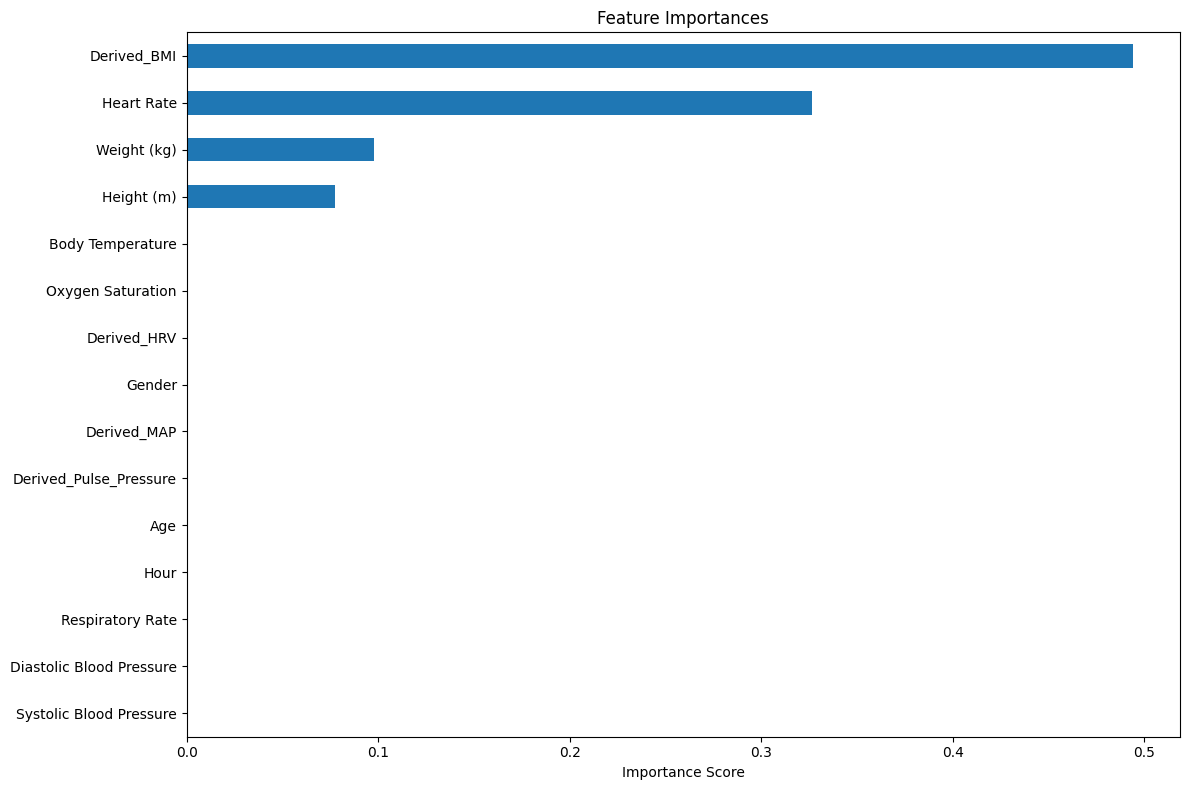

Streaming output truncated to the last 5000 lines.
[2024-03-04 16:26:46] Patient 197608 (26yo, 1): Risk Probability: 89.40% → High Risk

[2024-03-04 16:25:46] Patient 197609 (81yo, 0): Risk Probability: 100.00% → High Risk

[2024-03-04 16:24:46] Patient 197610 (35yo, 1): Risk Probability: 91.00% → High Risk

[2024-03-04 16:23:46] Patient 197611 (68yo, 0): Risk Probability: 94.38% → High Risk

[2024-03-04 16:22:46] Patient 197612 (59yo, 1): Risk Probability: 98.19% → High Risk

[2024-03-04 16:21:46] Patient 197613 (30yo, 0): Risk Probability: 89.17% → High Risk

[2024-03-04 16:20:46] Patient 197614 (75yo, 0): Risk Probability: 94.50% → High Risk

[2024-03-04 16:19:46] Patient 197615 (53yo, 0): Risk Probability: 4.71% → Low Risk
  ALERTS: Abnormal Temperature (36.1°C)

[2024-03-04 16:18:46] Patient 197616 (65yo, 0): Risk Probability: 85.19% → High Risk

[2024-03-04 16:17:46] Patient 197617 (84yo, 0): Risk Probability: 11.22% → Low Risk

[2024-03-04 16:16:46] Patient 197618 (46yo, 0): Ris

In [14]:
# Install required libraries (if not pre-installed in Colab)
!pip install pandas scikit-learn imbalanced-learn matplotlib seaborn

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import time
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load the dataset
file_path = '/content/human_vital_signs_dataset_2024.csv'
data = pd.read_csv(file_path)

# Display dataset info
print("Dataset Overview:")
print(f"Shape: {data.shape}")
print("\nFirst 5 rows:")
print(data.head())
print("\nData Statistics:")
print(data.describe())
print("\nRisk Category Distribution:")
print(data['Risk Category'].value_counts())

# Data Preprocessing
print("\nPreprocessing data...")

# Convert timestamp to datetime and extract features
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Hour'] = data['Timestamp'].dt.hour
data['DayPart'] = pd.cut(data['Hour'],
                         bins=[0, 6, 12, 18, 24],
                         labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                         include_lowest=True)

# Encode categorical variables
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})
data['RiskBinary'] = data['Risk Category'].map({'Low Risk': 0, 'High Risk': 1})

# Feature selection
features = ['Heart Rate', 'Respiratory Rate', 'Body Temperature',
            'Oxygen Saturation', 'Systolic Blood Pressure',
            'Diastolic Blood Pressure', 'Age', 'Gender', 'Weight (kg)',
            'Height (m)', 'Derived_HRV', 'Derived_Pulse_Pressure',
            'Derived_BMI', 'Derived_MAP', 'Hour']
target = 'RiskBinary'

X = data[features]
y = data[target]

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
print("\nTraining Random Forest model...")
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)
model.fit(X_train_scaled, y_train)

# Evaluate model
y_pred = model.predict(X_test_scaled)
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance Visualization
feature_importances = pd.Series(model.feature_importances_, index=features)
plt.figure(figsize=(12, 8))
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('feature_importances.png')
plt.show()

# Real-time Monitoring Simulation
print("\nStarting real-time monitoring simulation...")
high_risk_patients = []

def check_vitals(patient_data):
    """Check vital signs against clinical thresholds"""
    alerts = []
    if patient_data['Heart Rate'] > 100 or patient_data['Heart Rate'] < 60:
        alerts.append(f"Abnormal Heart Rate ({patient_data['Heart Rate']} bpm)")
    if patient_data['Respiratory Rate'] > 20 or patient_data['Respiratory Rate'] < 12:
        alerts.append(f"Abnormal Respiratory Rate ({patient_data['Respiratory Rate']} bpm)")
    if patient_data['Oxygen Saturation'] < 95:
        alerts.append(f"Low SpO2 ({patient_data['Oxygen Saturation']}%)")
    if patient_data['Body Temperature'] > 37.5 or patient_data['Body Temperature'] < 36.1:
        alerts.append(f"Abnormal Temperature ({patient_data['Body Temperature']:.1f}°C)")
    return alerts

# Process each patient in the dataset
for i, row in data.iterrows():
    # Prepare input data
    input_data = row[features].values.reshape(1, -1)
    scaled_data = scaler.transform(input_data)

    # Make prediction
    risk_prob = model.predict_proba(scaled_data)[0][1]
    risk_status = "High Risk" if risk_prob > 0.65 else "Low Risk"

    # Check vital thresholds
    vital_alerts = check_vitals(row)

    # Generate report
    report = f"Patient {row['Patient ID']} ({row['Age']}yo, {row['Gender']}): "
    report += f"Risk Probability: {risk_prob:.2%} → {risk_status}"

    if vital_alerts:
        report += "\n  ALERTS: " + "; ".join(vital_alerts)
        high_risk_patients.append(row['Patient ID'])

    # Print report with timestamp
    timestamp = row['Timestamp'].strftime('%Y-%m-%d %H:%M:%S')
    print(f"\n[{timestamp}] {report}")

    # Simulate real-time delay
    time.sleep(0.1)

# Final summary
print("\n\nSimulation Complete!")
print(f"Detected {len(high_risk_patients)} high-risk patients")
print("High-risk Patient IDs:", high_risk_patients)

# Save model for future use
import joblib
joblib.dump(model, 'wearsenseai_model.pkl')
print("\nModel saved as 'wearsenseai_model.pkl'")


Enhanced Data Analysis:


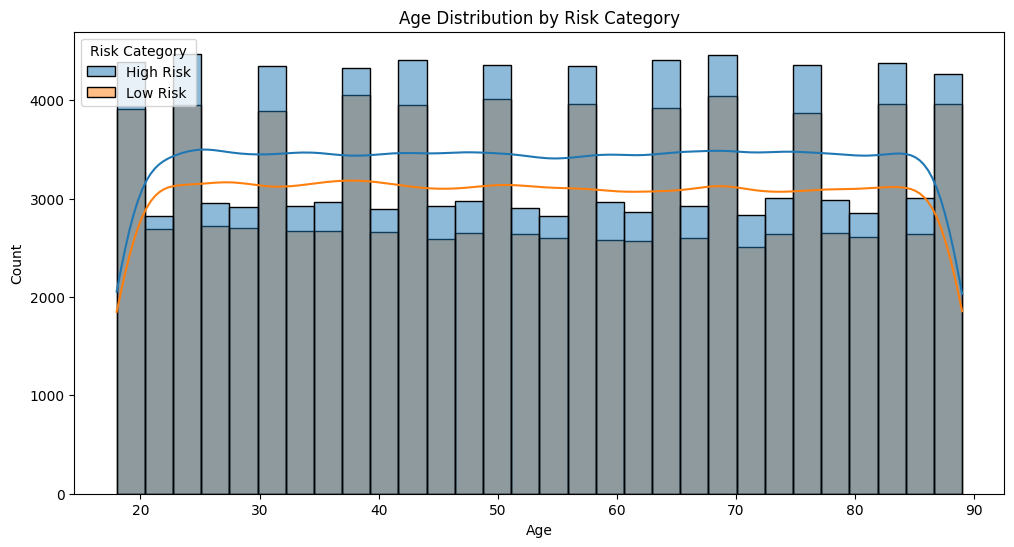

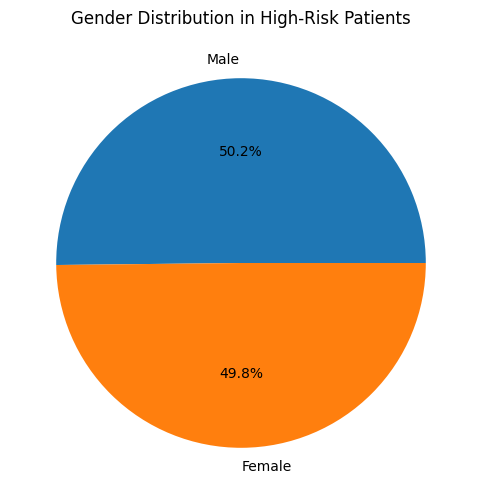


Feature Importance Analysis:


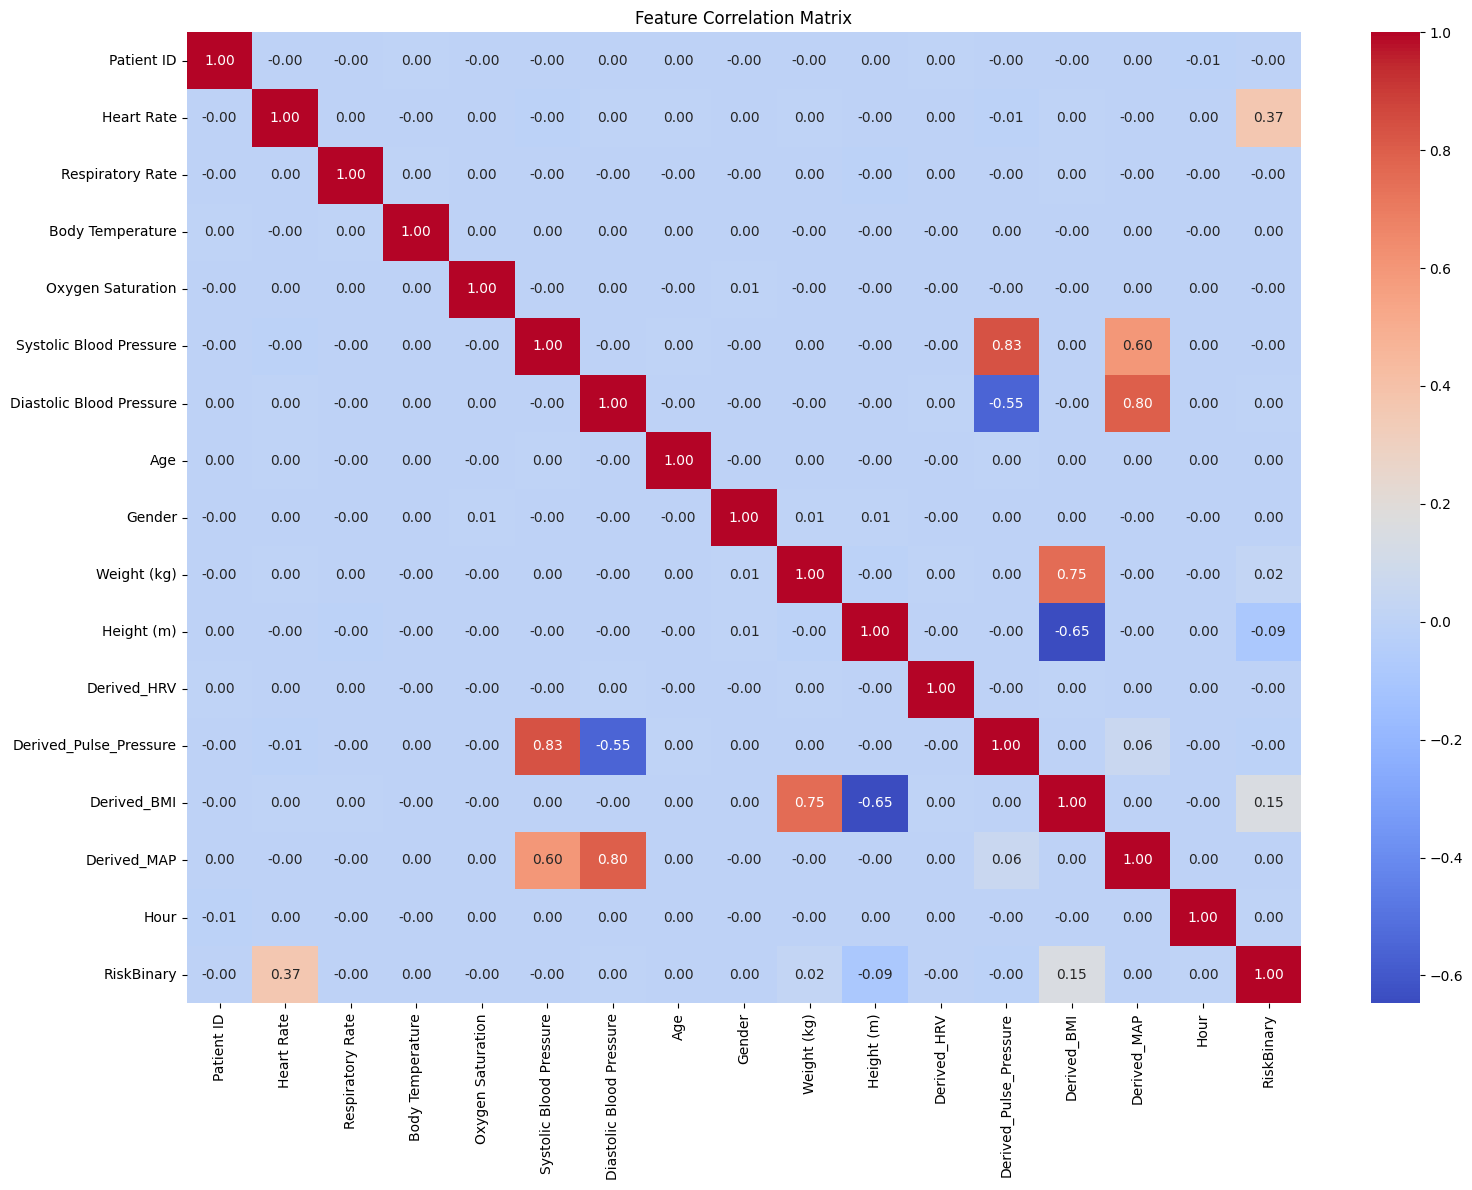

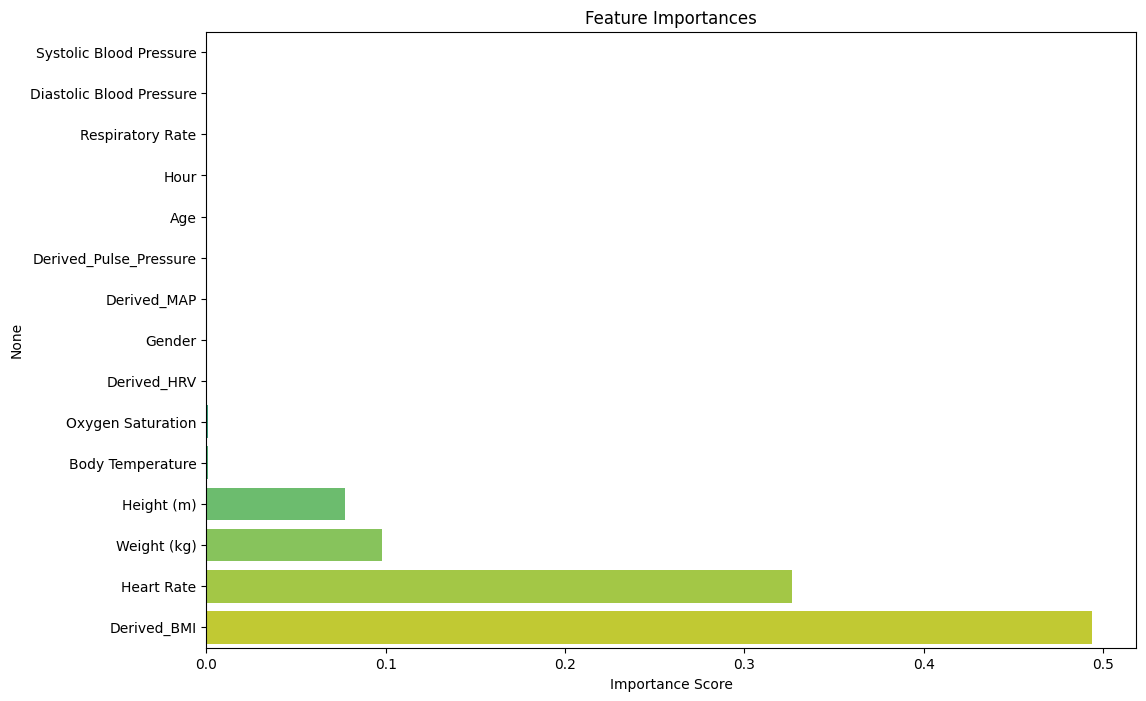


Post-Simulation Analysis:


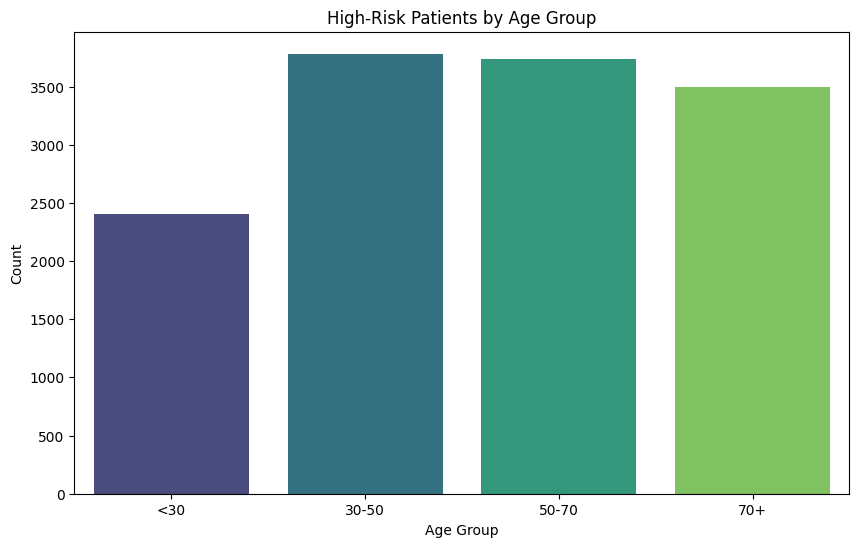

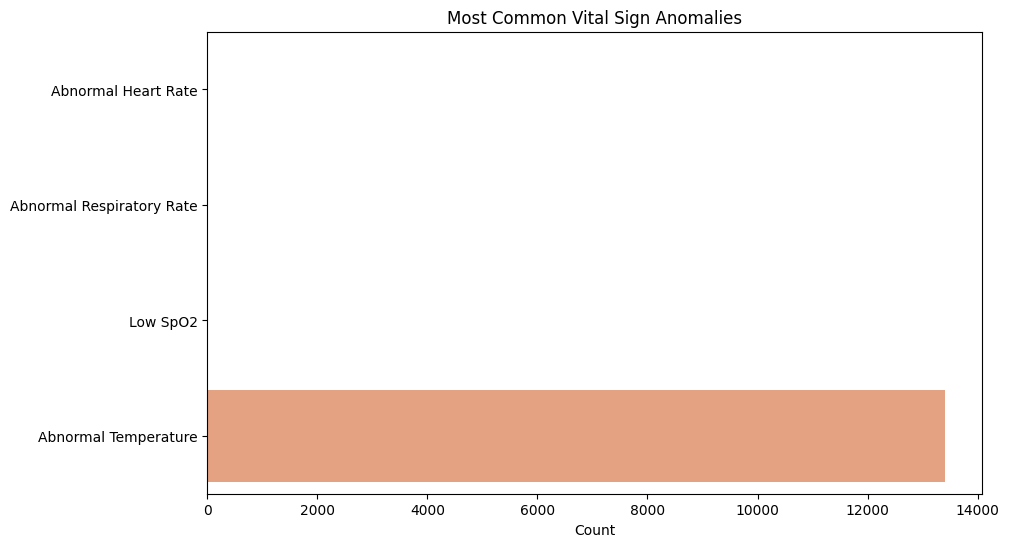

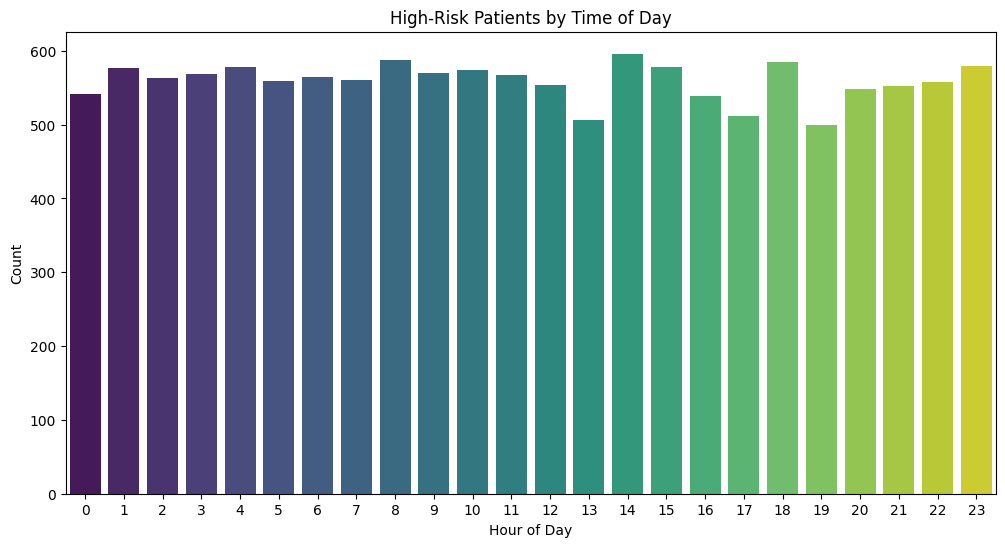

In [21]:

import plotly.express as px
from scipy import stats

# Enhanced EDA with Patient Distribution Plots
print("\nEnhanced Data Analysis:")

# Age distribution by risk category
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='Age', hue='Risk Category', kde=True, bins=30)
plt.title('Age Distribution by Risk Category')
plt.savefig('age_distribution.png')
plt.show()

# Gender distribution in high-risk patients
gender_risk = data[data['Risk Category'] == 'High Risk']['Gender'].value_counts()
plt.figure(figsize=(8, 6))
gender_risk.plot(kind='pie', autopct='%1.1f%%', labels=['Male', 'Female'])
plt.title('Gender Distribution in High-Risk Patients')
plt.ylabel('')
plt.savefig('gender_distribution.png')
plt.show()



# Enhanced Feature Importance with Statistical Analysis
print("\nFeature Importance Analysis:")
correlation_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()



# Enhanced Feature Importance Visualization
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances.sort_values(), y=feature_importances.sort_values().index, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.savefig('feature_importances.png')
plt.show()



# Post-Simulation Analysis
print("\nPost-Simulation Analysis:")

# High-risk patients by age group
high_risk_data = data[data['Patient ID'].isin(high_risk_patients)]
high_risk_data['Age Group'] = pd.cut(high_risk_data['Age'],
                                     bins=[0, 30, 50, 70, 100],
                                     labels=['<30', '30-50', '50-70', '70+'])

plt.figure(figsize=(10, 6))
sns.countplot(x='Age Group', data=high_risk_data, palette='viridis')
plt.title('High-Risk Patients by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.savefig('high_risk_age_groups.png')
plt.show()

# Most common vital sign anomalies
alert_counts = {'Abnormal Heart Rate': 0,
                'Abnormal Respiratory Rate': 0,
                'Low SpO2': 0,
                'Abnormal Temperature': 0}

for i, row in data.iterrows():
    alerts = check_vitals(row)
    for alert in alerts:
        if 'Heart Rate' in alert: alert_counts['Abnormal Heart Rate'] += 1
        elif 'Respiratory Rate' in alert: alert_counts['Abnormal Respiratory Rate'] += 1
        elif 'SpO2' in alert: alert_counts['Low SpO2'] += 1
        elif 'Temperature' in alert: alert_counts['Abnormal Temperature'] += 1

plt.figure(figsize=(10, 6))
sns.barplot(x=list(alert_counts.values()), y=list(alert_counts.keys()), palette='rocket')
plt.title('Most Common Vital Sign Anomalies')
plt.xlabel('Count')
plt.savefig('common_anomalies.png')
plt.show()

# Temporal patterns in high-risk patients
high_risk_data['Hour'] = high_risk_data['Timestamp'].dt.hour
plt.figure(figsize=(12, 6))
sns.countplot(x='Hour', data=high_risk_data, palette='viridis')
plt.title('High-Risk Patients by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.savefig('temporal_patterns.png')
plt.show()

# Interactive 3D plot of vital signs (requires plotly)
fig = px.scatter_3d(high_risk_data.head(500),
                    x='Heart Rate',
                    y='Oxygen Saturation',
                    z='Body Temperature',
                    color='Age',
                    size='Systolic Blood Pressure',
                    hover_data=['Patient ID', 'Age'],
                    title='Vital Signs of High-Risk Patients')
fig.write_html("vital_signs_3d.html")
fig.show()
